In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection

In [2]:
%matplotlib inline

In [3]:
# reading the file back in is a bit tricky!
target_df = pd.read_csv("../data/interim/tidy-economies.csv",
                        index_col=[0, 1],
                        header=[0])

In [4]:
target_df.head()

Cooking    Lighting      Others  Space Cooling  \
economy year                                                      
AUS     1985  270.172487  733.438730  792.892209      30.762606   
        1986  284.684809  778.301463  841.391572      32.644283   
        1987  297.184146  804.984343  870.237401      33.763442   
        1988  294.937808  820.991222  887.541818      34.434818   
        1989  300.633115  833.911032  901.508925      34.976714   

              Space Heating  Water Heating  
economy year                                
AUS     1985    2946.944593    1598.789375  
        1986    2991.419727    1704.558146  
        1987    3060.346201    1765.484468  
        1988    3055.982620    1749.111713  
        1989    3088.429142    1775.541073

In [124]:
macro_features_df = pd.read_csv("../data/interim/tidy-macro.csv",
                                index_col=[0, 1],
                                header=[0])

In [125]:
macro_features_df.head()

CSGDP    CSGDP%         GDP          GDPC        POP  \
economy year                                                              
AUS     1980  251.303595  0.571922  439.401502  30119.913863  14.588405   
        1981  263.586127  0.580499  454.068106  30727.525128  14.777243   
        1982  272.660848  0.581140  469.182359  31322.246995  14.979205   
        1983  271.427620  0.591651  458.763332  30192.442954  15.194641   
        1984  281.189221  0.586078  479.780916  31107.809920  15.423166   

                   POPU  
economy year             
AUS     1980  12.569300  
        1981  12.792439  
        1982  13.002993  
        1983  13.162165  
        1984  13.307374

In [147]:
macro_features_df.tail()

CSGDP    CSGDP%         GDP         GDPC         POP  \
economy year                                                              
VN      2046  259.673379  0.387357  670.372509  6145.878902  109.076752   
        2047  269.496367  0.387069  696.248888  6373.764517  109.236682   
        2048  279.690787  0.386781  723.124095  6611.160623  109.379296   
        2049  290.270678  0.386493  751.036685  6858.618905  109.502612   
        2050  301.250607  0.386206  780.026701  7116.706560  109.605011   

                   POPU  
economy year             
VN      2046  56.299311  
        2047  56.965619  
        2048  57.624513  
        2049  58.274662  
        2050  58.914886

In [126]:
household_features_df = pd.read_csv("../data/interim/tidy-households.csv",
                                    index_col=[0, 1],
                                    header=[0])

In [127]:
household_features_df.head()

ELC         HOA           IPH       PPH          TNH       URB
economy year                                                                
AUS     1990  1.0  148.565547  79957.957571  2.644279  6444.857294  0.854000
        1991  1.0  147.158250  78587.461549  2.644279  6531.837530  0.855412
        1992  1.0  146.534165  77969.263283  2.644279  6612.766966  0.856824
        1993  1.0  148.889562  80192.116075  2.644279  6689.158304  0.858236
        1994  1.0  151.266127  82473.365361  2.644279  6762.902417  0.859648

In [148]:
household_features_df.tail()

ELC         HOA           IPH       PPH           TNH       URB
economy year                                                                 
VN      2046  1.0  122.240468  71068.234270  3.344065  33935.050428  0.516144
        2047  1.0  124.549476  73207.825750  3.329376  34180.575246  0.521488
        2048  1.0  126.880349  75371.246367  3.314688  34422.242274  0.526832
        2049  1.0  129.238453  77568.511045  3.300000  34659.393939  0.532176
        2050  1.0  131.932371  80164.618268  3.300000  34736.363636  0.537520

# Feature engineering

I used historical data for the target activities as well as macro and household data for features. Many of the activities also exhibit a time trend so probably need to include the a time trend feature.

In [228]:
# use some lags of target variables
_one_year_ago_targets_df = (target_df.groupby("economy")
                                     .shift(1))
_two_years_ago_targets_df = (target_df.groupby("economy")
                                      .shift(2))
historical_features = _one_year_ago_targets_df.join(_two_years_ago_targets_df, lsuffix="_1", rsuffix="_2")

# also include current macro and household specific features
data = (target_df.join(historical_features)
                 .join(macro_features_df)
                 .join(household_features_df))
                                     

In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 644 entries, (AUS, 1985) to (VN, 2017)
Data columns (total 30 columns):
Cooking            630 non-null float64
Lighting           644 non-null float64
Others             644 non-null float64
Space Cooling      644 non-null float64
Space Heating      353 non-null float64
Water Heating      644 non-null float64
Cooking_1          609 non-null float64
Lighting_1         623 non-null float64
Others_1           623 non-null float64
Space Cooling_1    623 non-null float64
Space Heating_1    342 non-null float64
Water Heating_1    623 non-null float64
Cooking_2          588 non-null float64
Lighting_2         602 non-null float64
Others_2           602 non-null float64
Space Cooling_2    602 non-null float64
Space Heating_2    331 non-null float64
Water Heating_2    602 non-null float64
CSGDP              555 non-null float64
CSGDP%             555 non-null float64
GDP                644 non-null float64
GDPC               644 non-null float6

In [155]:
data.head()

Cooking    Lighting      Others  Space Cooling  \
economy year                                                      
AUS     1985  270.172487  733.438730  792.892209      30.762606   
        1986  284.684809  778.301463  841.391572      32.644283   
        1987  297.184146  804.984343  870.237401      33.763442   
        1988  294.937808  820.991222  887.541818      34.434818   
        1989  300.633115  833.911032  901.508925      34.976714   

              Space Heating  Water Heating   Cooking_1  Lighting_1  \
economy year                                                         
AUS     1985    2946.944593    1598.789375         NaN         NaN   
        1986    2991.419727    1704.558146  270.172487  733.438730   
        1987    3060.346201    1765.484468  284.684809  778.301463   
        1988    3055.982620    1749.111713  297.184146  804.984343   
        1989    3088.429142    1775.541073  294.937808  820.991222   

                Others_1  Space Cooling_1  ...         GDP          GDPC  \
economy year                               ...                             
AUS     1985         NaN              NaN  ...  504.966112  32238.060274   
        1986  792.892209        30.762606  ...  525.350245  33004.420831   
        1987  841.391572        32.644283  ...  538.775816  33292.357596   
        1988  870.237401        33.763442  ...  569.690301  34626.882497   
        1989  887.541818        34.434818  ...  591.735677  35403.617688   

                    POP       POPU  ELC  HOA  IPH  PPH  TNH  URB  
economy year                                                      
AUS     1985  15.663663  13.486012  NaN  NaN  NaN  NaN  NaN  NaN  
        1986  15.917572  13.704062  NaN  NaN  NaN  NaN  NaN  NaN  
        1987  16.183168  13.909213  NaN  NaN  NaN  NaN  NaN  NaN  
        1988  16.452255  14.133874  NaN  NaN  NaN  NaN  NaN  NaN  
        1989  16.713989  14.370091  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 30 columns]

In [156]:
data.tail()

Cooking    Lighting       Others  Space Cooling  \
economy year                                                        
VN      2013  7824.805134  333.746944  2278.701133     721.585264   
        2014  7744.359287  332.462406  2444.252550     837.431844   
        2015  4854.480576  377.018374  2589.006018     980.038646   
        2016  4465.316392  347.386044  3072.881094     930.433384   
        2017  4671.220138  360.265797  3199.189228    1000.133077   

              Space Heating  Water Heating    Cooking_1  Lighting_1  \
economy year                                                          
VN      2013            NaN    4513.131525  8008.697981  330.972088   
        2014            NaN    4500.338560  7824.805134  333.746944   
        2015            NaN    2502.958446  7744.359287  332.462406   
        2016            NaN    2374.371609  4854.480576  377.018374   
        2017            NaN    2153.651760  4465.316392  347.386044   

                 Others_1  Space Cooling_1  ...         GDP         GDPC  \
economy year                                ...                            
VN      2013  2108.921888       617.688407  ...  136.657572  1505.825550   
        2014  2278.701133       721.585264  ...  144.834689  1579.201964   
        2015  2444.252550       837.431844  ...  154.508616  1667.171892   
        2016  2589.006018       980.038646  ...  164.104855  1752.500167   
        2017  3072.881094       930.433384  ...  173.819863  1837.406681   

                    POP       POPU   ELC        HOA           IPH       PPH  \
economy year                                                                  
VN      2013  90.752592  29.430443  0.99  70.697554  20268.177601  3.828326   
        2014  91.713848  30.371288  0.99  71.451465  21158.705608  3.814087   
        2015  92.677076  31.333193  0.99  72.403298  22238.246619  3.799399   
        2016  93.640422  32.314724  0.99  73.330960  23280.064622  3.784710   
        2017  94.600648  32.992354  0.99  74.437574  24517.717807  3.770022   

                       TNH       URB  
economy year                          
VN      2013  23900.000000  0.323126  
        2014  24264.000000  0.329528  
        2015  24628.108760  0.335930  
        2016  24987.117051  0.342342  
        2017  25342.026258  0.348754  

[5 rows x 30 columns]

# Fit models for electricity demand

In [271]:
targets = ['Cooking', 'Lighting', 'Others', 'Space Cooling', 'Space Heating', 'Water Heating']

demand_models = {}
for economy, df in data.groupby(level="economy"):
    
    _processed_data = (df.dropna(how="all", axis=1)
                         .dropna(how="any", axis=0))

    _targets = _processed_data.columns.isin(targets)
    _processed_target = _processed_data.iloc[:, _targets]
    _processed_features = _processed_data.iloc[:, ~_targets]

    # regularized modeling pipeline (that guards against over-fitting to the training data!)
    _cv = model_selection.TimeSeriesSplit(n_splits=10) # since we are doing time-series forecasting!
    _prng = np.random.RandomState(42)
    _regressor = linear_model.MultiTaskElasticNetCV(cv=_cv, normalize=True, max_iter=1000, random_state=_prng)
    
    # non-regularized linear regression (to see the impact of over-fitting to training data!)
    #_regressor = linear_model.LinearRegression()
    
    demand_models[economy] = _regressor.fit(_processed_features, _processed_target)

/Users/pughdr/Desktop/aperc-training-final-day/env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:462: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random)


# Training Errors

In [272]:
predictions = {}
training_error = {}

for economy, df in data.groupby(level="economy"):
    
    _processed_data = (df.dropna(how="all", axis=1)
                         .dropna(how="any", axis=0))
    
    _targets = _processed_data.columns.isin(targets)
    _processed_target = _processed_data.iloc[:, _targets]
    _processed_features = _processed_data.iloc[:, ~_targets]
    
    # here we make the predictions
    _predictions = demand_models[economy].predict(_processed_features)
    _predictions_df = pd.DataFrame(data=_predictions,
                                   index=_processed_target.index,
                                   columns=_processed_target.columns)
    predictions[economy] = _predictions_df
    
    # here we compute the RMSE (units are ktoe)
    _rmse = metrics.mean_squared_error(_processed_target, _predictions_df)**0.5
    training_error[economy] = _rmse

In [273]:
def plot_training_errors(economy):
    _processed_data = (data.loc[economy, :]
                           .dropna(how="all", axis=1)
                           .dropna(how="any", axis=0))

    _targets = _processed_data.columns.isin(targets)
    _processed_target = _processed_data.iloc[:, _targets]
    _predictions = predictions[economy].loc[economy]
    
    _, n_targets = _processed_target.shape
    fig, axes = plt.subplots(1, n_targets, figsize=(20, 6))
    for n in range(n_targets):
        axes[n].plot(_processed_target.iloc[:, n], label="Target")
        axes[n].plot(_predictions.iloc[:, n], label="predictions")
        axes[n].set_ylabel("KTOE")
        axes[n].set_xlabel("Year")
        axes[n].set_title(_processed_target.columns[n])
        
    fig.tight_layout()
    axes[0].legend()
    
    return fig, axes

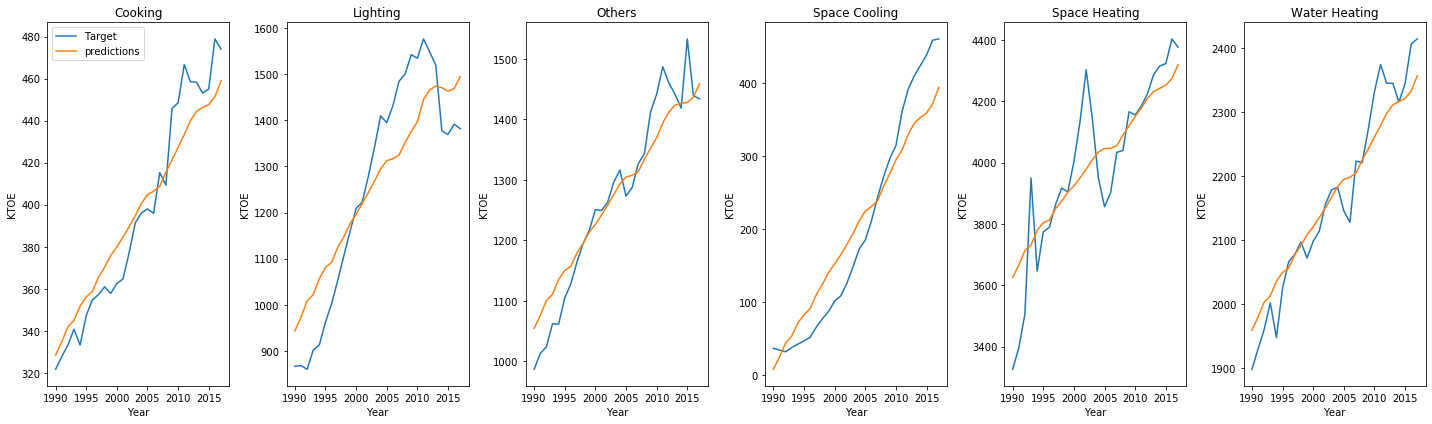

In [274]:
_ = plot_training_errors("AUS")

# Compute the forecasts from 2018 to 2050

If the models are over-fitting to the training data, then these forecasts are unlikely to be good (particularly at such long time horizons). I have tried to guard against over-fitting by using a form of [regularized linear regression](https://scikit-learn.org/stable/modules/linear_model.html#multi-task-elastic-net) and cross validation when fitting the models above but much more could/should be done.

In [242]:
forecasts = {}
for economy, df in data.groupby(level="economy"):
    
    _processed_data = (df.dropna(how="all", axis=1)
                         .dropna(how="any", axis=0))

    _targets = _processed_data.columns.isin(targets)
    _processed_target = _processed_data.iloc[:, _targets]
    _processed_features = _processed_data.iloc[:, ~_targets]
    
    _forecasts = []
    _current_features = _processed_features.loc[[(economy, 2017)]].values
    
    for _year in range(2018, 2050 + 1):
        # forecast combines next year's predicted targets plus existing forecasted values for macro and household 
        _predictions = demand_models[economy].predict(_current_features)
        _macro_forecast = (macro_features_df.loc[[(economy, _year)]]
                                            .values)
        _household_forecast = (household_features_df.loc[[(economy, _year)]]
                                                    .values)
        _forecast = np.hstack((_predictions, _macro_forecast, _household_forecast))
        _forecasts.append(_forecast)
        
        _current_features[:, sum(_targets):2*sum(_targets)] = _current_features[:, :sum(_targets)]
        _current_features[:, :sum(_targets)] = _predictions[0]

    _forecasts_df = pd.DataFrame(data=np.vstack(_forecasts),
                                 index=pd.RangeIndex(2018, 2050 + 1, 1),
                                 columns=_processed_target.columns.append(macro_features_df.columns).append(household_features_df.columns))
    forecasts[economy] = _forecasts_df

In [243]:
def plot_forecasts(economy):
    _processed_data = (data.loc[economy, :]
                           .dropna(how="all", axis=1)
                           .dropna(how="any", axis=0))

    _targets = _processed_data.columns.isin(targets)
    _processed_target = _processed_data.iloc[:, _targets]
    _predictions = forecasts[economy]

    _, n_targets = _processed_target.shape
    fig, axes = plt.subplots(1, n_targets, figsize=(20, 6))
    for n in range(n_targets):
        axes[n].plot(_predictions.iloc[:, n], label="forecast")
        axes[n].set_ylabel("KTOE")
        axes[n].set_xlabel("Year")
        axes[n].set_title(_processed_target.columns[n])
        
    fig.tight_layout()
    
    return fig, axes

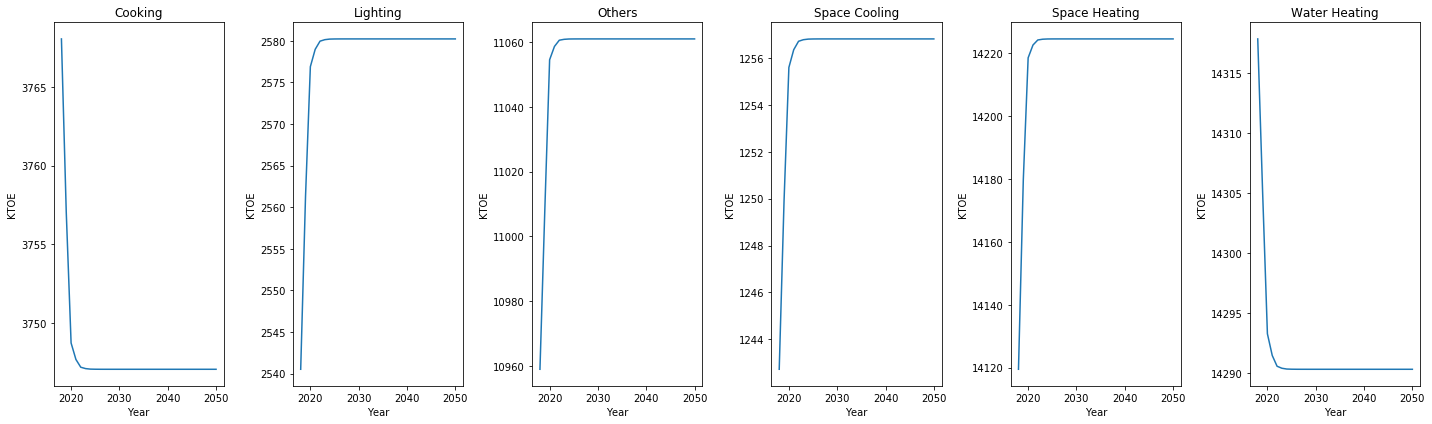

In [246]:
_ = plot_forecasts("JPN")

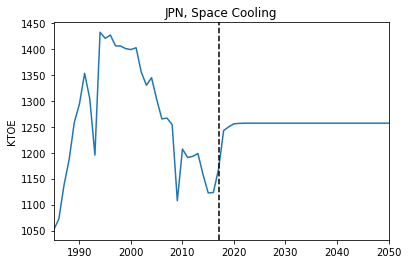

In [248]:
economy = "JPN"
activity = "Space Cooling"
_df= pd.concat([data.loc[economy], forecasts[economy]], sort=True)
(_df.loc[:, activity]
    .plot())
_ = plt.axvline(2017, c='k', ls='--') # demarcates between historical data and forecasted data
_ = plt.ylabel("KTOE")
_ = plt.title(f"{economy}, {activity}")